In [1]:
import nptdms as tdms
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import time

In [2]:
# user lib
from myMedFilter import *
from plot_hist import *
from fit_units import *
from extract_features import *

In [3]:
IS_TRANSFER = False
IS_MERGE    = False
IS_CUT      = True


# transfer TDMS to CSV

In [4]:
# transfer to csv
# add timestamp
if IS_TRANSFER:
# voltage 
    dir_file = "./电流电压/" 
    filename = "Voltage-Current-2019-11-19T08-55-08"
    suffix = ".tdms"
    dir_save = "./voltage_current_csv/phase1/"
    group_name = 'Voltage-Current'


    for (_,_,files) in os.walk(dir_file):
        df_file = pd.DataFrame()
        df_file['file'] = files
        df_file.to_csv("./temp/voltage_files.txt",index = False)
        for file in files:
            if file[-5:]==".tdms":
                filename = file[:-5]
                file_read = dir_file+filename+suffix
                file_save = dir_save+filename+".csv"
                try:
                    # read file
                    tdms_file = tdms.TdmsFile(file_read)
                    # transform tdms into dataframe
                    df = tdms_file.as_dataframe()
                    # change the columns name
                    df.columns = ["time","Ic","U_IGBT3_1","U_IGBT3_2","Uce"]

                    # drop some nansense columns
        #             df.drop(["N0","N1"],axis = 1,inplace = True)
                    try:
                        df.dropna(axis = 0,inplace = True)
                    except:
                        pass
                    # transform the string time into timestamp
                    timestamp = []
                    for t in df.time:
                        if t != "":
                            timestamp.append(time.mktime(time.strptime(t[0:-7],"%Y/%m/%dT%H:%M:%S"))+ float(t[-7:]))
                        else:
                            timestamp.append(0)
                    df["timestamp" ]= timestamp
                    df["timestamp"].replace(0,np.NaN,inplace = True)
                    # save file
                    df.to_csv(file_save)
                except:
                    print(file)
                    pass
      

In [5]:
if IS_TRANSFER:
    # temperature
    dir_file = "./温度/" 
    filename = "Temperature-2019-11-19T08-55-08"
    suffix = ".tdms"
    dir_save = "./temperature_csv/phase1/"


    for (_,_,files) in os.walk(dir_file):
        df_file = pd.DataFrame()
        df_file['file'] = files
        df_file.to_csv("./temp/temperature_files.txt",index = False)
        for file in files:
            if file[-5:]==".tdms":
                filename = file[:-5]
                file_read = dir_file+filename+suffix
                file_save = dir_save+filename+".csv"

                try:
                    # read file
                    tdms_file = tdms.TdmsFile(file_read)
                    # transform tdms into dataframe
                    df = tdms_file.as_dataframe()
                    # change the columns name
                    try:
                        df.columns = ["time","Tbase_Cu","Tsink_IGBT3_2","Tsink_IGBT3_1","Tj_IGBT3_2","Tj_IGBT3_1"]
                    except:
                        df.columns = ["time","Tbase_Cu","Tsink_IGBT3_2","Tsink_IGBT3_1","Tj_IGBT3_2","Tj_IGBT3_1",
                                      "Tsink_IGBT4_2","Tsink_IGBT4_1","Tj_IGBT4_1"]
                    # drop some nansense columns
                    try:
                        df.dropna(axis = 0,inplace = True)
                    except:
                        pass
                    # transform the string time into timestamp
                    timestamp = []
                    for t in df.time:
                        if t != "":
                            timestamp.append(time.mktime(time.strptime(t[0:-7],"%Y/%m/%dT%H:%M:%S"))+ float(t[-7:]))
                        else:
                            timestamp.append(0)
                    df["timestamp" ]= timestamp
                    df["timestamp"].replace(0,np.NaN,inplace = True)
                    # save file
                    df.to_csv(file_save)

                except:
                    print(file)
                    pass

## merge temperature and voltage data on time 

In [6]:
# merge data and save inplace
# delete "time" and 'timestamp' using "t"
if IS_MERGE:
    dir_temp = "./temperature_csv/" 
    dir_volt = "./voltage_current_csv/" 
    prefix_temp = "Temperature-"
    prefix_volt = "Voltage-Current-"
    time_str = "2019-12-09T17-58-55"
    suffix = ".csv"

    file_err = []
    for (_,_,files) in os.walk(dir_volt):
        for file in files:
            time_str = file[-23:-4]
            # read file
            try:
                file_temp = dir_temp+prefix_temp+time_str+suffix
                file_volt = dir_volt+prefix_volt+time_str+suffix
                volt_df = pd.read_csv(file_volt,index_col = 0)
                temp_df = pd.read_csv(file_temp,index_col = 0)
            except:
                print("read error: ",time_str)
                file_err.append(file)

            try:
                # 去除不规整的volt数据
                select_df = volt_df.dropna(axis = 0)
                l = select_df.index.values
                m= np.where(l[1:]-l[:-1]==51)
                volt_df = volt_df.loc[l[m[0][0]]:,:]
            except:
                print("select error: ",time_str)
                file_err.append(file)

            try:
                # 重新定义时间
                volt_df["t"] = volt_df["timestamp"].round(1)
                volt_df.drop(["timestamp","time"],axis = 1,inplace = True )
                temp_df["t"] = temp_df["timestamp"].round(1)
                temp_df.drop(["timestamp","time"],axis = 1,inplace = True )
            except:
                print("def t error: ",time_str)
                file_err.append(file)

            try:
                # merge temp to voltage
                merge_df = pd.merge(volt_df,temp_df,on = "t", how = "left")
                # save
                merge_df.to_csv(file_volt,index = False)
                # merge voltage to temperature
                merge_df = pd.merge(temp_df,volt_df,on = "t", how = "left")
                # save
                merge_df.to_csv(file_temp,index = False)
            except:
                print("merge error: ",time_str)
                file_err.append(file)

    err_file_df = pd.DataFrame()
    err_file_df["file"] = file_err
    err_file_df.to_csv("./temp/error_files.txt",index = False)

# cut into cycle

In [7]:
# cut voltage file into cycles
# name as (n_round,dur,Tmax,Tmin1,Tmin2, t)
if IS_CUT:
    dir_volt = "./voltage_current_csv/phase1/" 
    dir_save = "./voltage_current_cycle/phase1/"
    prefix_volt = "Voltage-Current-"
#     time_str = "2019-12-09T17-58-55"
    suffix = ".csv"

    n_round = 0
    for (_,_,files) in os.walk(dir_volt):
        for file in files:
            time_str = file[-23:-4]
            try:
                # read file
                file_volt = dir_volt+prefix_volt+time_str+suffix
                volt_df = pd.read_csv(file_volt)
                # get index of max T and min T
                select_df = volt_df.dropna(inplace = False)
                l = select_df["Tj_IGBT3_1"].values
                l[1:-1] = (l[:-2]+l[1:-1]+l[2:])/3
                ix = select_df.index.values  # index of temp
                m = l[1:]-l[:-1]> 0
                m = m.astype(np.int8)
                n = m[1:]-m[:-1]
                n = np.insert(n,0,values = 1)
                n = np.append(n,values = 1)  # 1 0 0 0 -1 0 0 1 0 0 -1 0 0 1 //the same size as ix
                i_Tmax = np.where(n==-1)[0]  # 
                i_Tmin = np.where(n==1)[0]

                # cut and save
                for i in range(len(i_Tmax)):
                    n_round += 1
                    dur = i_Tmin[i+1]-i_Tmin[i]
                    Tmax = l[i_Tmax[i]]
                    Tmin1 = l[i_Tmin[i]]
                    Tmin2 = l[i_Tmin[i+1]]
                #     print(n_round,dur,Tmax,Tmin1,Tmin2)
                    df = volt_df.loc[ix[i_Tmin[i]+1]:ix[i_Tmin[i+1]],:]
                    t = np.around(df.t.values[0],decimals = -1)
                    filename = str(n_round)+"-"+str(int(dur))+"-"+str(int(Tmin1))+"-"+str(int(Tmax))+"-"+str(int(Tmin2))+"-"+str(int(t))
                    df.to_csv(dir_save+filename+".csv",index = False)
            except:
                print(time_str)



In [8]:
from myMedFilter import *
if IS_CUT:
    dir_temp = "./temperature_csv/phase1/" 
    dir_save = "./temperature_cycle/phase1/"
    prefix_temp = "Temperature-"
    # time_str = "2019-12-09T17-58-55"
    suffix = ".csv"

    n_round = 0
    for (_,_,files) in os.walk(dir_volt):
        for file in files:
            time_str = file[-23:-4]
            try:
                # read file
                file_volt = dir_temp+prefix_temp+time_str+suffix
                volt_df = pd.read_csv(file_volt)
                # get index of max T and min T
    #             select_df = volt_df.dropna(inplace = False)
                l = volt_df["Tj_IGBT3_1"].values
                l[1:-1] = (l[:-2]+l[1:-1]+l[2:])/3
                l = myMedFilter(l)
                ix = volt_df.index.values
                m = l[1:]-l[:-1]> 0
                m = m.astype(np.int8)
                n = m[1:]-m[:-1]
                n = np.insert(n,0,values = 1)
                n = np.append(n,values = 1)
                i_Tmax = np.where(n==-1)[0]
                i_Tmin = np.where(n==1)[0]

                # cut and save
                for i in range(len(i_Tmax)):
                    n_round += 1
                    dur = (i_Tmin[i+1]-i_Tmin[i])/10
                    Tmax = l[i_Tmax[i]]
                    Tmin1 = l[i_Tmin[i]]
                    Tmin2 = l[i_Tmin[i+1]]
                #     print(n_round,dur,Tmax,Tmin1,Tmin2)
                    df = volt_df.loc[ix[i_Tmin[i]+1]:ix[i_Tmin[i+1]],:]
                    t = np.around(df.t.values[0],decimals = -1)
                    filename = str(n_round)+"-"+str(int(dur))+"-"+str(int(Tmin1))+"-"+str(int(Tmax))+"-"+str(int(Tmin2))+"-"+str(int(t))
                    df.to_csv(dir_save+filename+".csv",index = False)
            except:
                print(time_str)



# collect Temperature info to choose useful csv

In [5]:
# collect all temperature data
dir_temp = "./temperature_cycle/phase1/" 
suffix = ".csv"
prefix = "phase1_"

all_df = pd.DataFrame(columns = ["round","dur_second","T_min1","T_max","T_min2"])
for (_,_,files) in os.walk(dir_temp):
    for file in files:
        try:
            l = file[:-4].split("-")
            l = [i for i in l if i!=""]
            l = np.array([int(i) for i in l]).reshape(1,6)
            df = pd.DataFrame(l, columns = ["round","dur_second","T_min1","T_max","T_min2","t"])
            all_df = pd.concat([all_df,df],axis = 0)
        except:
            print(file)

all_df.sort_values(by = 'round',inplace = True)
all_df.to_csv("./temp/"+prefix+"all_temp_info.csv",index = False)    
print(all_df.shape)
all_df.head()    

(26723, 6)


,T_max,T_min1,T_min2,dur_second,round,t
0,41,19,36,10,1,1.575886e+09
0,62,36,41,20,2,1.575886e+09
0,73,41,49,20,3,1.575886e+09
0,88,49,58,20,4,1.575886e+09
0,99,58,66,20,5,1.575886e+09


In [17]:
# choose useful cycles
# read csv
all_df  = pd.read_csv("./temp/"+prefix+"all_temp_info.csv")
print("raw shape:",all_df.shape)

# culculate delta
all_df['T_delta1'] = all_df['T_max']-all_df['T_min1']
all_df['T_delta2'] = all_df['T_max']-all_df['T_min2']

# delete some error data
all_df = all_df.loc[all_df['T_max'].values<180,:]
all_df = all_df.loc[all_df['T_min1'].values>10,:]
all_df = all_df.loc[all_df['T_min2'].values>10,:]
print("shape after delete error:",all_df.shape)

# select the useful data
# Tmax [160,175] 
# Tmin1 [80,100]
# Tmin2 [80,100]
s = np.all( [all_df['T_max'].values > 160, all_df['T_max'].values <178,
             all_df['T_min1'].values > 83, all_df['T_min1'].values < 102,
             all_df['T_min2'].values > 83, all_df['T_min2'].values < 102,
            ],
           axis = 0)
all_df = all_df.loc[ s,:]
all_df.to_csv("./temp/"+prefix+"all_useful_df.csv")
print("shape of useful data:",all_df.shape)
all_df.head()

raw shape: (26723, 6)
shape after delete error: (26723, 8)
shape of useful data: (26642, 8)


,T_max,T_min1,T_min2,dur_second,round,t,T_delta1,T_delta2
14,164,86,94,40,15,1.575886e+09,78,70
15,170,94,98,39,16,1.575886e+09,76,72
16,170,98,98,38,17,1.575886e+09,72,72
17,169,98,99,37,18,1.575886e+09,71,70
18,170,99,99,37,19,1.575886e+09,71,71


# choose IGBT3_1 data only

In [25]:
# choose IGBT3_1 data only
all_df = pd.read_csv("./temp/phase1_all_useful_df.csv")

save_temp = "./temperature_IGBT3_1/phase1/" 
dir_temp  = "./temperature_cycle/phase1/" 
suffix = ".csv"
str_info = "15-40-86-165-94"

for i in range(all_df.shape[0]):
    str_info = (str(all_df['round'].values[i])+ "-"+ str(all_df['dur_second'].values[i])+ "-" +str(all_df['T_min1'].values[i])
                + "-" +str(all_df['T_max'].values[i])+ "-"+ str(all_df['T_min2'].values[i])+ "-"+ str(int(all_df['t'].values[i])))
    filename = dir_temp+ str_info +suffix
    try:
        temp_df  = pd.read_csv(filename)
        temp_df = temp_df.loc[:,["Tbase_Cu","Tsink_IGBT3_1","Tj_IGBT3_1","t","Ic","Uce","Power","dT_IGBT3_1","Rth_IGBT3_1"]]
        temp_df.to_csv(save_temp+ str_info +suffix, index = False)
    except Exception as e:
        print(e)
        print(filename)
        break
        

# Analyze IGBT 3-1 data

In [26]:
from fit_units import *
from extract_features import *
# extract the voltage and temperature info
all_df = pd.read_csv("./temp/phase1_all_useful_df.csv")

dir_temp  = "./temperature_IGBT3_1/phase1/" 
suffix = ".csv"
str_info = "15-40-86-165-94"

df = pd.DataFrame()
for i in range(all_df.shape[0]):
    str_info = (str(all_df['round'].values[i])+ "-"+ str(all_df['dur_second'].values[i])+ "-" +str(all_df['T_min1'].values[i])
                + "-" +str(all_df['T_max'].values[i])+ "-"+ str(all_df['T_min2'].values[i])+ "-"+ str(int(all_df['t'].values[i])))
    filename = dir_temp+ str_info +suffix
    try:
        temp_df  = pd.read_csv(filename)
        temp_df.dropna(axis = 0,subset={"Uce"},inplace=True)
        df  = pd.concat([df,temp_df],axis = 0)
    except:
        print(filename)
# choose Uce > 1 which means IGBT turns on 
df = df.loc[df.Uce.values<1.0,:]
# unify
df = fit_units(df)
# extract Rth and Power
df = extract_features(df)
df.to_csv("./temp/phase1_all_T_U_I.csv",index = False)
print(df.shape)
df.head()

(409068, 9)


,Tbase_Cu,Tsink_IGBT3_1,Tj_IGBT3_1,t,Ic,Uce,Power,dT_IGBT3_1,Rth_IGBT3_1
1,82.829453,84.145805,92.146673,1.575886e+09,2.895693,0.250646,NaN,NaN,NaN
11,84.080452,93.156021,114.151393,1.575886e+09,2.893199,0.255346,NaN,NaN,NaN
21,87.821823,96.490524,118.930026,1.575886e+09,2.881038,0.244999,NaN,NaN,NaN
31,90.982422,99.017258,122.286921,1.575886e+09,2.886482,0.254565,NaN,NaN,NaN
41,94.198853,101.739090,125.562396,1.575886e+09,2.877510,0.248553,NaN,NaN,NaN


In [147]:
from drop_outliers import *
# choose data between 2019/12/12 15:56 and 2019/12/19 9:20
# drop outliers
t1 = '2019/12/12 15:56:00'
t2 = '2019/12/19 09:20:00'
t_base = "2019/10/01 00:00:00"
stamp_base = time.mktime(time.strptime(t_base,"%Y/%m/%d %H:%M:%S"))
stamp1 = time.mktime(time.strptime(t1,"%Y/%m/%d %H:%M:%S")) - stamp_base
stamp2 = time.mktime(time.strptime(t2,"%Y/%m/%d %H:%M:%S")) - stamp_base 
df = pd.read_csv("./temp/phase1_all_T_U_I.csv")
print(df.shape)
df = df.iloc[df.t.values<stamp2,:]
df = df.iloc[df.t.values>stamp1,:]
print(df.shape)
# drop outliers using statistic 3std regular
_,ix = drop_outliers(df["Ic"],filter_size = 64,threshold = 2)  # get outliers of Ic
df = df.iloc[np.logical_not(ix),:]
_,ix = drop_outliers(df["Uce"],filter_size = 64,threshold = 2) # get outliers of Uce
df = df.iloc[np.logical_not(ix),:] 
df.to_csv("./temp/phase1_useful_T_U_I.csv",index = False)
print(df.shape)
df.head()

(409068, 9)
(298012, 9)
34.46626428571429
0.17620952263526204
6.978282
0.26559832581550663
(283601, 9)


,Tbase_Cu,Tsink_IGBT3_1,Tj_IGBT3_1,t,Ic,Uce,Power,dT_IGBT3_1,Rth_IGBT3_1
92320,80.69,93.44,123.18,6278510.3,34.8750,6.4437,224.724038,29.74,0.132340
92321,86.12,98.04,130.51,6278511.3,34.8760,6.6301,231.231368,32.47,0.140422
92322,91.10,100.93,134.80,6278512.3,34.7292,6.3657,221.075668,33.87,0.153205
92323,96.56,104.04,138.75,6278513.3,34.6746,6.3589,220.492314,34.71,0.157420
92324,100.14,107.16,142.68,6278514.3,34.7766,6.7143,233.500525,35.52,0.152120


In [159]:
# choose by Tj
df = pd.read_csv("./temp/phase1_useful_T_U_I.csv")
def choose_data_by_Tj(df, Tj , span = 1):
    df = df.loc[df.Tj_IGBT3_1.values> Tj-span, :]
    df = df.loc[df.Tj_IGBT3_1.values< Tj+span, :]
    return df

for Tj in [90,100,110,120,130,140,150,160,170]:
    df_t = choose_data_by_Tj(df, Tj, 1)
    df_t.to_csv("./temp/phase1_"+str(Tj)+"_T_U_I.csv")

print(df_t.shape)
# df_t.head()


(8839, 9)


In [151]:
# choose by Ic
I = 34.3
span = 0.01
df_t = df.loc[df.Ic.values> I-span, :]
df_t = df_t.loc[df_t.Ic.values< I+span, :]
df_t.to_csv("./temp/phase1_I"+str(I)+"_T_U_I.csv")

(3628, 9)


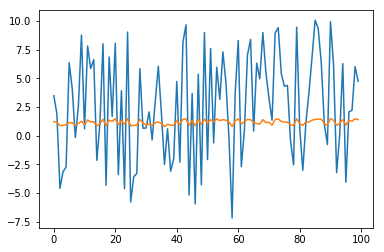

In [155]:
# df_t = df_t.loc[df_t.Ic.values>34,:]
# df_t = df_t.loc[df_t.Uce.values>6.25,:]
print(df_t.shape)
plt.clf()
plt.figure()
plt.plot(df_t.Tj_IGBT3_1.values[-100:]-160)
plt.plot(df_t.Uce.values[-100:]-6)
plt.show()

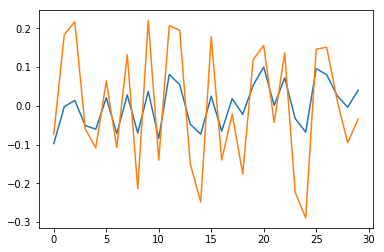

In [78]:
plt.clf()
plt.figure()
plt.plot(df_t.Ic.values[:30]-np.mean(df_t.Ic.values[:30]))
plt.plot(df_t.Uce.values[:30]-np.mean(df_t.Uce.values[:30]))  # 变化幅度比电流大 +-0.2
plt.show()

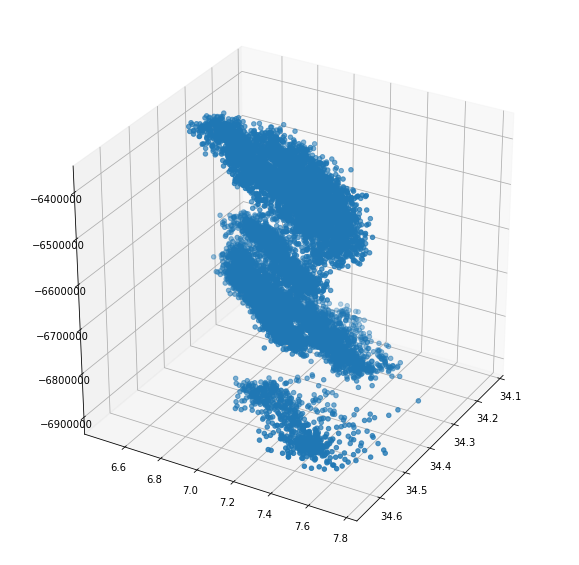

In [71]:
from mpl_toolkits.mplot3d import Axes3D 
elev = 30
azim = 30
plt.clf()
fig = plt.figure(figsize=(10,10)) 
ax = fig.gca(projection='3d') 
# ax = fig.add_subplot(111, projection='3d') 
ax.scatter(df_t.Ic.values[-10000:],df_t.Uce.values[-10000:],-df_t.t.values[-10000:])
ax.view_init(elev=elev,azim=azim)
plt.show()

In [ ]:
t_base = "2019/10/01 00:00:00"
stamp_base = time.mktime(time.strptime(t_base,"%Y/%m/%d %H:%M:%S"))
stamp1 = 8004869 + stamp_base
time.strftime('%Y/%m/%d %H:%M:%S',time.localtime(stamp1))